### 1.1 Importar Libs

In [1]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import json
import pickle
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, roc_curve)
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, randint
from joblib import dump, load
import warnings
warnings.filterwarnings('ignore')

# Importar funções dos módulos customizados
from ml_utils import gmean_score, evaluate_model, load_and_prepare_datasets
from search_utils import (plot_search_history, multiple_randomized_search,
                          plot_search_history_from_loaded, 
                          load_search_results, get_best_params_from_saved,
                          save_search_results, save_final_results)
try:
    import lightgbm as lgb
except:
    print("❌ LightGBM não encontrado. Instale com: pip install lightgbm")

# Configurações de plotagem
plt.rcParams['figure.figsize'] = [12, 8]
sns.set_style("whitegrid")

print("Bibliotecas importadas com sucesso!")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")
print(f"LightGBM: {lgb.__version__}")

Bibliotecas importadas com sucesso!
Pandas: 2.3.3
NumPy: 2.3.3
Scikit-learn: 1.7.2
LightGBM: 4.6.0


### 1.2 Definir Nome do Modelo

In [3]:
# Definir nome do modelo para uso em salvamento e exibição
MODEL_NAME = "LightGBM"
print(f"Modelo: {MODEL_NAME}")

Modelo: LightGBM


### 1.3 Carregar Datasets

In [5]:
# Carregamento e preparação inicial dos dados
print("Carregando datasets...")

# Carregar e preparar datasets usando função do módulo
(X_train, X_test, y_train, y_test, 
 X_train_scaled, X_test_scaled, 
 train_data, test_data, scaler) = load_and_prepare_datasets()

print(f"Dataset de treino: {train_data.shape}")
print(f"Dataset de teste: {test_data.shape}")

print("\nDistribuição das classes:")
print("Treino:", y_train.value_counts().to_dict())
print("Teste:", y_test.value_counts().to_dict())

Carregando datasets...
Dataset de treino: (72795, 17)
Dataset de teste: (8180, 17)

Distribuição das classes:
Treino: {0.0: 54175, 1.0: 18620}
Teste: {0.0: 5894, 1.0: 2286}


In [6]:
train_data.head()

,Hour,HR,O2Sat,Temp,MAP,Resp,BUN,Creatinine,Glucose,Hct,Hgb,WBC,Platelets,Gender,HospAdmTime,ICULOS,SepsisLabel
0,-0.828259,-0.396817,0.890288,-1.189896,0.268219,0.158164,0.391841,0.579093,1.632205,0.855053,0.706987,1.433318,0.068024,-1.140335,0.356849,-0.838308,0.0
1,-0.478847,-0.673800,-1.872530,0.324391,1.492201,-0.386455,-0.161934,-0.113524,-0.304515,1.156973,0.656064,-0.813046,1.079563,-1.140335,0.304841,-0.489607,0.0
2,-0.804965,0.544922,-0.644611,0.450581,1.249928,1.065862,-0.662070,-0.345514,0.976526,1.689773,1.623609,-1.137985,-0.149065,0.876935,0.357194,-0.815061,0.0
3,-0.525435,-0.396817,0.583308,-1.745135,-0.084618,0.702783,0.746309,0.543080,-1.476333,0.002573,-0.311482,-0.705572,-0.116992,0.876935,-0.584873,-0.536101,0.0
4,-0.665200,-1.061575,-0.644611,0.488439,0.387085,-0.567994,0.272113,-2.489717,-0.248842,0.748493,0.808834,-0.088417,0.940833,-1.140335,0.357194,-0.675581,0.0


## 2. Sampling para Busca de Hiperparâmetros

In [7]:
# ======================================================================
# SAMPLING ESTRATIFICADO PARA BUSCA DE HIPERPARÂMETROS
# ======================================================================

print("=== PREPARAÇÃO DE AMOSTRA PARA BUSCA DE HIPERPARÂMETROS ===")

# Amostra estratificada do dataset de treino
_, X_sample, _, y_sample = train_test_split(
    X_train_scaled, y_train, 
    test_size=0.05,  
    stratify=y_train,
    random_state=10
)

print(f"Dataset original de treino: {X_train_scaled.shape[0]:,} amostras")
print(f"Amostra para busca de hiperparâmetros: {X_sample.shape[0]:,} amostras")
print(f"Redução: {(1 - X_sample.shape[0]/X_train_scaled.shape[0])*100:.1f}%")

print("\nDistribuição das classes na amostra:")
print("Amostra:", pd.Series(y_sample).value_counts().to_dict())
print("Original:", y_train.value_counts().to_dict())

=== PREPARAÇÃO DE AMOSTRA PARA BUSCA DE HIPERPARÂMETROS ===
Dataset original de treino: 72,795 amostras
Amostra para busca de hiperparâmetros: 3,640 amostras
Redução: 95.0%

Distribuição das classes na amostra:
Amostra: {0.0: 2709, 1.0: 931}
Original: {0.0: 54175, 1.0: 18620}


## 3 Definir Folds

In [8]:
# Configuração da validação cruzada estratificada
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## 4. LightGBM - Busca de Hiperparâmetros

In [11]:
# ======================================================================
# 4.1 BUSCA DE HIPERPARAMETROS
# ======================================================================

print(f"=== BUSCA DE HIPERPARÂMETROS - {MODEL_NAME} ===")

# Definição do Espaço de Hiperparâmetros para LightGBM (apenas parâmetros variáveis)
param_distributions = {
    'n_estimators': randint(100, 300),  # Número de árvores
    'max_depth': randint(3, 12),  # Profundidade máxima das árvores
    'learning_rate': uniform(0.5, 1.4),  # Taxa de aprendizado
    'num_leaves': randint(50, 150),  # Número de folhas por árvore
    'feature_fraction': uniform(0.3, 0.5),  # Fração de features por árvore
    'bagging_fraction': uniform(0.4, 0.55),  # Fração de amostras para cada árvore
    'bagging_freq': randint(5, 30),  # Frequência de bagging
    'lambda_l1': uniform(1, 0.8),  # Regularização L1
    'lambda_l2': uniform(1.5, 2),  # Regularização L2
    'min_child_samples': randint(50, 100),  # Amostras mínimas por folha
    'min_child_weight': uniform(2, 15.5),  # Peso mínimo das folhas
}

# Múltiplas execuções do RandomizedSearchCV
print(f"Iniciando busca de hiperparâmetros para {MODEL_NAME}...")
model_search, model_all_searches, best_params = multiple_randomized_search(
    estimator=lgb.LGBMClassifier(
        objective='binary',          # Para classificação binária
        metric='binary_logloss',     # Métrica de avaliação
        boosting_type='gbdt',        # Gradient Boosting Decision Tree
        random_state=42,             # Reprodutibilidade
        n_jobs=-1,                   # Usar todos os cores
        verbosity=-1                 # Silencioso
    ),
    param_distributions=param_distributions,
    X=X_sample,                  
    y=y_sample,
    cv_strategy=cv_strategy,
    n_searches=20,                
    n_iter_per_search=80,       
    scoring='f1',
    n_jobs=-1,
)

# Seleção da Melhor Configuração
print(f"\n--- RESULTADOS {MODEL_NAME} ---")
print("Melhores hiperparâmetros:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"\nMelhor F1-Score (CV): {model_search.best_score_:.4f}")

=== BUSCA DE HIPERPARÂMETROS - LightGBM ===
Iniciando busca de hiperparâmetros para LightGBM...
Executando 20 buscas com 80 iterações cada...

Busca 1/20...
Melhor score desta busca: 0.5409
Melhor configuração desta busca: {'bagging_fraction': np.float64(0.8525969686318664), 'bagging_freq': 24, 'feature_fraction': np.float64(0.676210617972542), 'lambda_l1': np.float64(1.2115788627431432), 'lambda_l2': np.float64(2.093692752407941), 'learning_rate': np.float64(0.7526571347685326), 'max_depth': 10, 'min_child_samples': 71, 'min_child_weight': np.float64(14.015752487483399), 'n_estimators': 170, 'num_leaves': 50}
Melhor score geral até agora: 0.5409

Busca 2/20...
Melhor score desta busca: 0.5450
Melhor configuração desta busca: {'bagging_fraction': np.float64(0.9477961954648297), 'bagging_freq': 9, 'feature_fraction': np.float64(0.3306921618417283), 'lambda_l1': np.float64(1.1580088772189048), 'lambda_l2': np.float64(2.3815865123191706), 'learning_rate': np.float64(0.7164342913957028), '

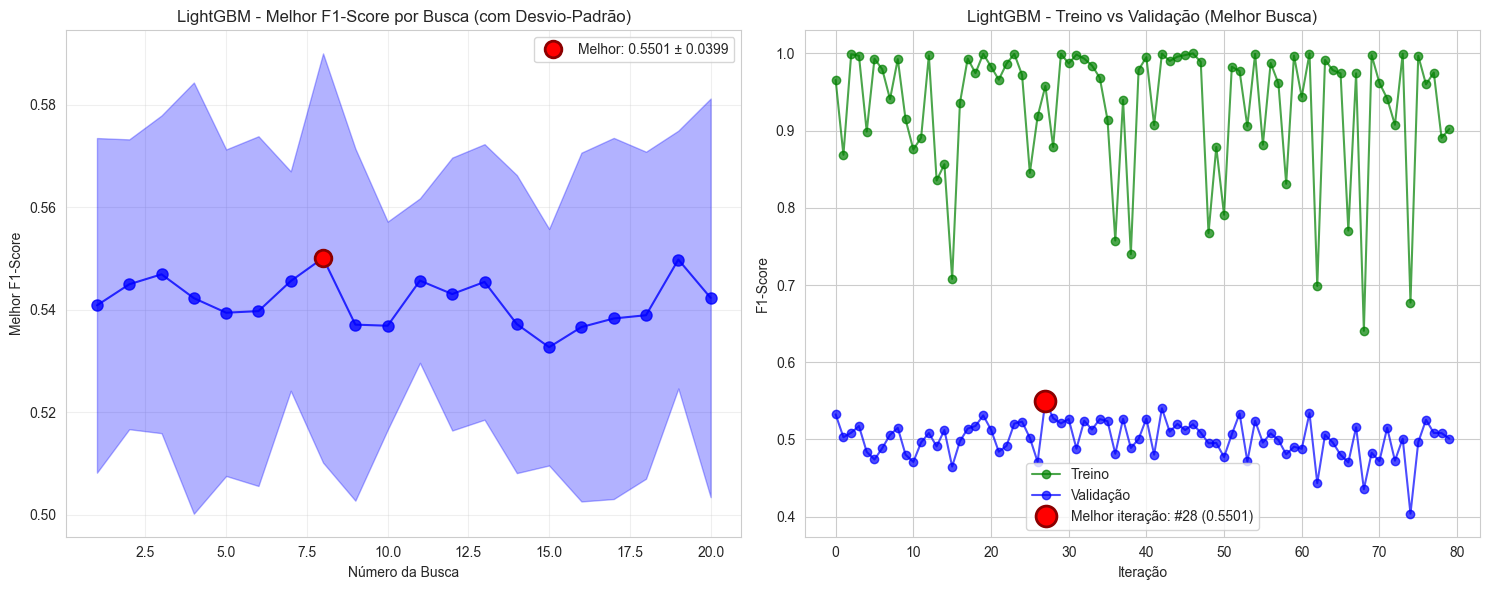

In [12]:
# Registro de Desempenho - plotar evolução
plot_search_history(model_all_searches, model_search, MODEL_NAME)

In [13]:
# ======================================================================
# 4.5 ANÁLISE DAS MELHORES CONFIGURAÇÕES ENCONTRADAS
# ======================================================================

print(f"=== TOP 20 MELHORES CONFIGURAÇÕES - {MODEL_NAME} ===")

# Extrair os melhores resultados de cada busca
best_configs = []

for i, search_result in enumerate(model_all_searches):
    config = {
        'Busca': i + 1,
        'F1_Score': search_result['best_score'],
        'N_Estimators': search_result['best_params']['n_estimators'],
        'Max_Depth': search_result['best_params']['max_depth'],
        'Learning_Rate': search_result['best_params']['learning_rate'],
        'Num_Leaves': search_result['best_params']['num_leaves'],
        'Feature_Fraction': search_result['best_params']['feature_fraction'],
        'Bagging_Fraction': search_result['best_params']['bagging_fraction'],
        'Bagging_Freq': search_result['best_params']['bagging_freq'],
        'Lambda_L1': search_result['best_params']['lambda_l1'],
        'Lambda_L2': search_result['best_params']['lambda_l2'],
        'Min_Child_Samples': search_result['best_params']['min_child_samples'],
        'Min_Child_Weight': search_result['best_params']['min_child_weight'],
    }
    best_configs.append(config)

# Converter para DataFrame e ordenar por F1-Score
results_df = pd.DataFrame(best_configs)
results_df = results_df.sort_values('F1_Score', ascending=False).reset_index(drop=True)
results_df['Ranking'] = range(1, len(results_df) + 1)

# Reordenar colunas
results_df = results_df[['Ranking', 'Busca', 'F1_Score', 'N_Estimators', 'Max_Depth', 
                        'Learning_Rate', 'Num_Leaves', 'Feature_Fraction', 'Bagging_Fraction',
                        'Bagging_Freq', 'Lambda_L1', 'Lambda_L2', 'Min_Child_Samples', 'Min_Child_Weight']]

# Mostrar tabela formatada
print("Top 20 Configurações (ordenadas por F1-Score Binário):")
print("-" * 180)
print(results_df.to_string(index=False, float_format='%.4f'))

# Estatísticas resumidas
print(f"\n--- ESTATÍSTICAS DAS CONFIGURAÇÕES ---")
print(f"Melhor F1-Score: {results_df['F1_Score'].max():.4f}")
print(f"F1-Score médio: {results_df['F1_Score'].mean():.4f}")
print(f"Desvio padrão: {results_df['F1_Score'].std():.4f}")
print(f"F1-Score mínimo: {results_df['F1_Score'].min():.4f}")

=== TOP 20 MELHORES CONFIGURAÇÕES - LightGBM ===
Top 20 Configurações (ordenadas por F1-Score Binário):
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Ranking  Busca  F1_Score  N_Estimators  Max_Depth  Learning_Rate  Num_Leaves  Feature_Fraction  Bagging_Fraction  Bagging_Freq  Lambda_L1  Lambda_L2  Min_Child_Samples  Min_Child_Weight
       1      8    0.5501           122         10         0.5571         107            0.7570            0.8422            11     1.5124     2.4056                 70           13.9254
       2     19    0.5498           194          5         0.5932          83            0.5039            0.6440            25     1.5408     2.7515                 93            2.2242
       3      3    0.5469           189          9         0.5043         139            0.7241            0.7894            21     1.3300     1.9929     

## 5. Salvar Resultados de Busca

In [14]:
# Salvar Resultados da Busca de Hiperparâmetros usando função do módulo
search_df = save_search_results(
    model_name=MODEL_NAME,
    model_search=model_search,
    model_all_searches=model_all_searches,
    n_searches=20,
    n_iter_per_search=15,
    scoring='f1',
    cv_folds=5,
    top_params_columns=['n_estimators', 'max_depth', 'learning_rate', 'num_leaves', 
                       'feature_fraction', 'bagging_fraction'],
    searches_folder='searches'
)

=== SALVANDO RESULTADOS DA BUSCA - LIGHTGBM ===
  ✅ Todos os Resultados salvos: searches\lightgbm_all_searches.csv
  Total de configurações testadas: 1,600
  ✅ Resumo salvo: searches\lightgbm_search_summary.json

--- ESTATÍSTICAS DA BUSCA LIGHTGBM ---
Melhor F1-Score: 0.5501
Desvio padrão do melhor: 0.0399
F1-Score médio geral: 0.4946
F1-Score mínimo: 0.2350
F1-Score máximo: 0.5501


## 5.2 Carregar Resultado de busca

In [5]:
#### 4.2 Carregar Resultados Salvos (Função Auxiliar)
# Exemplo de uso da função (não executar se já temos os resultados)
loaded_results = load_search_results(MODEL_NAME)

=== CARREGANDO RESULTADOS DE BUSCA - LIGHTGBM ===
✅ Resultados detalhados carregados: 400 configurações
✅ Resumo carregado: F1-Score = 0.1382
⚠️  Arquivo não encontrado: searches\lightgbm_full_search.pkl


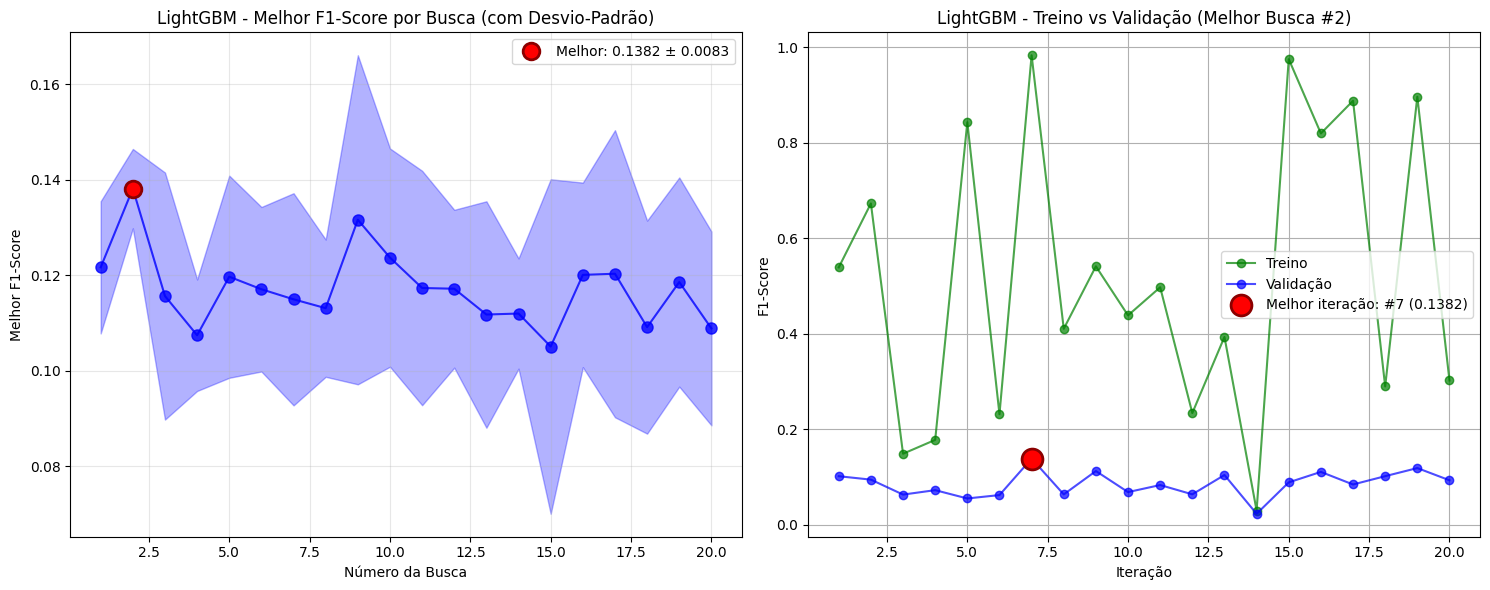

In [8]:
# Plotar a história da busca a partir dos resultados carregados
plot_search_history_from_loaded(loaded_results, MODEL_NAME)

In [15]:

#### 4.3 Recuperar Melhores Parâmetros para Uso Posterior
# Exemplo de uso (descomente se precisar carregar parâmetros salvos):
if 'loaded_results' in locals():
    best_params = get_best_params_from_saved(MODEL_NAME)
    if best_params:
        print(f"✅ Parâmetros carregados: {best_params}")
    best_score = loaded_results['summary']['best_overall_score']
    print(f"✅ Melhor F1-Score carregado: {best_score:.4f}")
else:
    best_params = model_search.best_params_
    best_score = model_search.best_score_
    print(f"✅ Usando parâmetros da busca atual: {best_params}")
    print(f"✅ Melhor F1-Score da busca atual: {best_score:.4f}")

✅ Usando parâmetros da busca atual: {'bagging_fraction': np.float64(0.842151716495456), 'bagging_freq': 11, 'feature_fraction': np.float64(0.7570037025570987), 'lambda_l1': np.float64(1.5124175494650127), 'lambda_l2': np.float64(2.4056000059987044), 'learning_rate': np.float64(0.5570545873899307), 'max_depth': 10, 'min_child_samples': 70, 'min_child_weight': np.float64(13.925407265312021), 'n_estimators': 122, 'num_leaves': 107}
✅ Melhor F1-Score da busca atual: 0.5501


## 6. Treinar Modelo Final e Salvar

In [16]:
# Treinamento Final com melhores hiperparâmetros
best_model = lgb.LGBMClassifier(**best_params)
best_model.fit(X_train_scaled, y_train)

print(f"\nModelo final {MODEL_NAME} treinado: {best_model}")

# Criar pasta se não existir
os.makedirs('models', exist_ok=True)

# Salvar modelo treinado
dump(best_model, f'models/{MODEL_NAME.lower()}_trained.joblib')
print(f"Modelo salvo: models/{MODEL_NAME.lower()}_trained.joblib")


Modelo final LightGBM treinado: LGBMClassifier(bagging_fraction=np.float64(0.842151716495456), bagging_freq=11,
               feature_fraction=np.float64(0.7570037025570987),
               lambda_l1=np.float64(1.5124175494650127),
               lambda_l2=np.float64(2.4056000059987044),
               learning_rate=np.float64(0.5570545873899307), max_depth=10,
               min_child_samples=70,
               min_child_weight=np.float64(13.925407265312021),
               n_estimators=122, num_leaves=107)
Modelo salvo: models/lightgbm_trained.joblib


## 7. Avaliação Final e Salvamento dos Resultados

In [82]:
# Carregar modelo
loaded_model = load(f'models/{MODEL_NAME.lower()}_trained.joblib')

In [17]:
print(f"=== AVALIAÇÃO E SALVAMENTO DOS RESULTADOS - {MODEL_NAME} ===")

# Criar pastas se não existirem
os.makedirs('results', exist_ok=True)

# Avaliação completa do modelo
print("\nAvaliando performance do modelo...")


if 'loaded_model' in locals():
    model = loaded_model
else:
    model = best_model

X_train_eval = X_train_scaled
y_train_eval = y_train
X_test_eval = X_test_scaled
y_test_eval = y_test

# Avaliar modelo
train_metrics, test_metrics, y_pred = evaluate_model(
    best_model, X_train_eval, X_test_eval, y_train_eval, y_test_eval, MODEL_NAME
)

=== AVALIAÇÃO E SALVAMENTO DOS RESULTADOS - LightGBM ===

Avaliando performance do modelo...


In [18]:
# Salvar resultados finais usando função do módulo
model_final_results = save_final_results(
    model_name=MODEL_NAME,
    best_params=best_params,
    best_score=best_score,
    train_metrics=train_metrics,
    test_metrics=test_metrics,
    y_pred=y_pred,
    y_test=y_test_eval,
    X_train_scaled=X_train_eval,
    X_test_scaled=X_test_eval,
    results_folder='results'
)

# Mostrar resumo
print(f"\n--- RESUMO {MODEL_NAME} ---")
print(f"F1-Score CV: {model_final_results['best_cv_score']:.4f}")
print(f"F1-Score Teste: {test_metrics['f1']:.4f}")
print(f"Acurácia Teste: {test_metrics['accuracy']:.4f}")
print(f"Precisão Teste: {test_metrics['precision']:.4f}")
print(f"Recall Teste: {test_metrics['recall']:.4f}")
print(f"G-Mean Teste: {test_metrics['gmean']:.4f}")
if test_metrics['auc_roc']:
    print(f"AUC-ROC Teste: {test_metrics['auc_roc']:.4f}")

✅ Resultados LightGBM salvos em: results\lightgbm_results.json

--- RESUMO LightGBM ---
F1-Score CV: 0.5501
F1-Score Teste: 0.4609
Acurácia Teste: 0.7790
Precisão Teste: 0.7238
Recall Teste: 0.3381
G-Mean Teste: 0.5668
AUC-ROC Teste: 0.8011
